In [1]:
##################################
#
# Implementation of the Linear Logic Recurrent Neural Network (LLRNN)
#

################
# GLOBAL FLAGS #
################

use_model             = 'ntm' # ntm, pattern_ntm
task                  = 'copy' # copy, repeat copy, pattern
epoch                 = 100 # number of training epochs, default to 200
num_classes           = 10 # number of symbols, INCLUDING initial and terminal symbols
N                     = 30 # length of input sequences for training, default to 20, INCLUDING initial and terminal symbols
Ntest                 = 35 # length of sequences for testing, default to N, INCLUDING initial and terminal symbols
batch_size            = 250 # default to 500 (too large does not fit on GPUs)
controller_state_size = 100 # dimension of the internal state space of the controller, default 100
memory_address_size   = 128 # number of memory locations, default 20
memory_content_size   = 20 # size of vector stored at a memory location, default 5
powers_ring1          = [0,-1,1] # powers of R used on ring 1, default [0,-1,1]
powers_ring2          = [0,-1,1] # powers of R used on ring 2, default [0,-1,1]
LOG_DIR               = '/tmp/log' # default /tmp/log
num_training          = 10000 # default to int(training_percent * (num_classes-2)**N)
num_test              = num_training
init_symbol           = num_classes - 2
term_symbol           = num_classes - 1
seq_length_min        = 4

##########
# NOTES
#
# 1. Always put the zero power first in powers_ring since the code assumes this is there
# 2. The initial and terminal symbols are always from the end of the list of symbols, so they
# are respectively num_classes - 2 and num_classes - 1. So the number of symbols which are
# not initial or terminal is num_classes - 2

In [2]:
%matplotlib notebook

# The next three lines are recommend by TF
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas
import collections
import six
import math
import time
import random

from tensorflow.python.ops.rnn_cell_impl import _RNNCell as RNNCell
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh

# Our libraries
import ntm
import seqhelper
import learnfuncs

In [3]:
#######################
# SETUP TASKS
#
# Our sequences are of one-hot vectors, which we interpret as follows:
#
# [1.0, 0.0, 0.0] = 0
# [0.0, 1.0, 0.0] = 1
# [0.0, 0.0, 1.0] = 2 etc
#
# We write our sequences and functions referring to sequences of integers,
# and then convert to one-hot vectors for integration with TF.

# Below N_out and Ntest_out are the lengths of the outputs in both the training
# and testing regimes respectively. Since outputs do not include the initial and terminal
# symbols, these default to N - 2 and Ntest - 2 respectively.

###########
# COPY TASK
if( task == 'copy' ):
    func_to_learn = learnfuncs.f_identity
    N_out = N - 2
    Ntest_out = Ntest - 2

##################
# REPEAT COPY TASK
# put n zeros before the 1, for a copy task with n + 1 copies
if( task == 'repeat copy' ):
    no_of_copies = 2
    pattern = [0]*(no_of_copies - 1) + [1]
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = no_of_copies * (N - 2)
    Ntest_out = no_of_copies * (Ntest - 2)

##############
# PATTERN TASK
if( task == 'pattern 1' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,1,1] # so (a,b,c,d,e,f,...) goes to (a,a,b,c,c,d,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = (N - 2) + divmod(N - 2, 2)[0] # N - 2 plus the number of times 2 divides N - 2
    Ntest_out = (Ntest - 2) + divmod(Ntest - 2, 2)[0]

# Give an example input/output pair
a = [random.randint(0,num_classes-3) for i in range(N - 2)]
fa = func_to_learn(a)

print("Under the chosen function, the sequence")
print(a)
print("is mapped to")
print(fa)

Under the chosen function, the sequence
[3, 2, 0, 4, 0, 4, 1, 2, 4, 7, 4, 3, 3, 0, 6, 0, 5, 2, 7, 2, 4, 3, 3, 0, 2, 7, 7, 3]
is mapped to
[3, 2, 0, 4, 0, 4, 1, 2, 4, 7, 4, 3, 3, 0, 6, 0, 5, 2, 7, 2, 4, 3, 3, 0, 2, 7, 7, 3]


In [4]:
####################
# INITIALISE STATE #
####################

one_hots = seqhelper.one_hot_vectors(num_classes)
input_size = num_classes # dimension of the input space I
state_size = 0

#####
# NTM

def init_state_ntm(batch_size, css, mas, mcs):
    state_size = css + 2*mas + mas * mcs
    
    ra = [0.0]*mas
    ra[0] = 1.0
    batch_address = np.zeros([batch_size,mas]) + ra
    
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)    
    init_read_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    init_write_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    init_memory = tf.truncated_normal([batch_size, mas*mcs], 0.0, 1e-6, dtype=tf.float32)
    
    state = tf.concat([init_controller_state,init_read_address,init_write_address,init_memory],1)
    return state_size, state

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size, memory_address_size, memory_content_size)
    cell = ntm.NTM(state_size,input_size,controller_state_size,memory_address_size,memory_content_size, powers_ring1)

#############
# PATTERN NTM

def init_state_pattern_ntm(batch_size, css, mas, mcs, pr1):
    state_size = css + 4*mas + mas * mcs + mas * len(pr1)
    
    ra = [0.0]*mas
    ra[0] = 1.0
    batch_address = np.zeros([batch_size,mas]) + ra
    
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)    
    init_read_address1 = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas])
    init_write_address1 = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas])
    init_read_address2 = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas])
    init_write_address2 = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas])

    init_memory1 = tf.truncated_normal([batch_size, mas*mcs], 0.0, 1e-6, dtype=tf.float32)
    init_memory2 = tf.truncated_normal([batch_size, mas*len(pr1)], 0.0, 1e-6, dtype=tf.float32)
    
    state = tf.concat([init_controller_state,init_read_address1,init_write_address1,
                       init_read_address2,init_write_address2,
                       init_memory1,init_memory2],1)
    
    return state_size, state

if( use_model == 'pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, memory_address_size, memory_content_size, powers_ring1)
    cell = ntm.PatternNTM(state_size,input_size,controller_state_size,memory_address_size,memory_content_size, powers_ring1, powers_ring2)
    

In [5]:
################
# DEFINE MODEL #
################

inputs = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]
targets = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]

# Used in order to flag that we share weights across iterations.
# Note that the training and test phases use all the same weights.
reuse = False

# Set up training graph
read_addresses = []
write_addresses = []
read_addresses2 = []
write_addresses2 = []
gamma_writes = []
gamma_reads = []
ss = []
rnn_outputs = []
    
for i in range(N + N_out):
    # Logging
    if( use_model == 'ntm' ):
        h0, curr_read, curr_write, _ = tf.split(state, [controller_state_size,memory_address_size,memory_address_size,-1], 1)

    if( use_model == 'pattern_ntm' ):
        h0, curr_read, curr_write, curr_read2, curr_write2, _ = tf.split(state, [controller_state_size,
                            memory_address_size,memory_address_size,memory_address_size,memory_address_size,-1], 1)

    #### RUN MODEL ####
    output, state = cell(inputs[i],state,'NTM',reuse)
    rnn_outputs.append(output)
    ###################
    
    # More logging
    read_addresses.append(curr_read[0,:])
    write_addresses.append(curr_write[0,:])
    
    if( use_model == 'pattern_ntm' ):
        read_addresses2.append(curr_read2[0,:])
        write_addresses2.append(curr_write2[0,:])

    #with tf.variable_scope("NTM",reuse=True):
    #    W_gamma_write = tf.get_variable("W_gamma_write", [controller_state_size,1])
    #    B_gamma_write = tf.get_variable("B_gamma_write", [])
    #    gamma_write = 1.0 + tf.nn.relu(tf.matmul(h0,W_gamma_write) + B_gamma_write) # shape [batch_size,1]
        
    #    W_gamma_read = tf.get_variable("W_gamma_read", [controller_state_size,1])
    #    B_gamma_read = tf.get_variable("B_gamma_read", [])
    #    gamma_read = 1.0 + tf.nn.relu(tf.matmul(h0,W_gamma_read) + B_gamma_read) # shape [batch_size,1]
        
    #    W_s = tf.get_variable("W_s", [controller_state_size,len(powers_ring1)])
    #    B_s = tf.get_variable("B_s", [len(powers_ring1)])
    #    s = tf.nn.softmax(tf.matmul(h0,W_s) + B_s) # shape [batch_size,len(powers)]

    #gamma_writes.append(gamma_write[0,:])
    #gamma_reads.append(gamma_read[0,:])
    #ss.append(s[0,:])
    reuse = True

# Final fully connected layer
with tf.variable_scope("final_layer"):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size],initializer=init_ops.constant_initializer(0.0))

# Note: prediction is a length N list of tensors of shape [None,input_size], where
# the jth row of prediction[d] is, for the jth input sequence in the batch,
# the probability distribution over symbols for the output symbol in position d.

# Note: We allow the length of input sequences to vary between batches, which means
# that the cross entropy needs to be masked to the relevant part of the output

# Note: we use log_softmax to avoid precision issues with floats causing log(0) to create NaNs

logits = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs]
prediction = [tf.nn.log_softmax(logit) for logit in logits] 
ce = [tf.reduce_sum(targets[i] * prediction[i]) for i in range(N + N_out)] # an array of numbers
mask = [tf.sign(tf.reduce_max(tf.abs(targets[i]))) for i in range(N + N_out)]
ce_mask = [ce[i] * mask[i] for i in range(N + N_out)]
cross_entropy = -tf.add_n(ce_mask)
cross_entropy /= tf.add_n(mask) # DEBUG do we really need this?
# NOTE: here in creating the mask we are assuming that batches have the same sequence length
                    
optimizer = tf.train.RMSPropOptimizer(1e-4,decay=0.9,momentum=0.9)
minimize = optimizer.minimize(cross_entropy)
mistakes = [tf.not_equal(tf.argmax(targets[i], 1), tf.argmax(prediction[i], 1)) for i in range(N + N_out)]
errors = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes]

# Summaries
errors_mask = [errors[i] * mask[i] for i in range(N + N_out)]
mean_error = tf.add_n(errors_mask)
mean_error /= tf.add_n(mask)
tf.summary.scalar('error', mean_error)

# Initialise the model
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

merged_summaries = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

[<tf.Tensor 'gradients/NTM_57/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_56/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_55/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_54/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_53/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_52/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_51/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_50/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_49/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_48/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_47/

In [6]:
############
# TRAINING #
############

random.seed()

pre_train_time = time.time()

# Training
no_of_batches = int(num_training/batch_size)

###################
# Note on sequences
#
# Our sequences are of varying length, in the alphabet {0,...,num_classes - 3}.
# Each input sequence begins with an initial symbol and ends with a terminal symbol
# (the value of which are num_classes - 2 and num_classes - 1 by default). Output
# sequences do not have either an initial nor a terminal symbol.
#
# Both input and output sequences are written on a "tape" of length N + N_out.
# Input sequences are aligned at the BEGINNING of the tape, and all remaining space
# is filled with terminal symbols. Output sequences are aligned at the END OF THE 
# MATCHING INPUT, with all remaining space filled with zero vectors.
#
# Example: suppose N = N_out = 10, and num_classes = 10 so that init_symbol = 8
# and term_symbol = 9. Then a sequence of length 8 (seq_length = 10 below) is
#
# a = [4, 4, 5, 6, 3, 3, 6, 7]
#
# which written on the tape is
#
# [8, 4, 4, 5, 6, 3, 3, 6, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
#
# If we are performing the copy task, so that the output sequence is also a, then
# the output written on the tape will be (notice the alignment)
#
# [-, -, -, -, -, -, -, -, -, 4, 4, 5, 6, 3, 3, 6, 7, -, -, -]
#
# where - is a symbol whose encoding is the zero vector.

error_means = []

for i in range(epoch):
    for j in range(no_of_batches):
        inp = []
        out = []

        # We sample each batch on the fly from the set of all sequences. Each
        # batch has a fixed length of the sequences. Recall that all input seqs
        # have an initial and terminal symbol, so if seq_length = 10 then there
        # are eight positions for the "content" symbols
        seq_length = random.randint(seq_length_min,N)
        
        for z in range(batch_size):
            a = [random.randint(0,num_classes-3) for k in range(seq_length-2)]
            fa = func_to_learn(a)
            a = [init_symbol] + a + [term_symbol] + [term_symbol for k in range(N+N_out-seq_length)]
            a_onehot = [one_hots[e] for e in a]
            fa_onehot = [[0.0]*num_classes for k in range(seq_length-1)] + \
                        [one_hots[e] for e in fa] + \
                        [[0.0]*num_classes for k in range(N+N_out-(seq_length-1)-len(fa))]
            inp.append(np.array(a_onehot))
            out.append(np.array(fa_onehot))        
        
        # An annoying thing here is that we cannot use a list as a key in a 
        # dictionary. The workaround we found on StackOverflow here:
        # http://stackoverflow.com/questions/33684657/issue-feeding-a-list-into-feed-dict-in-tensorflow)
        feed_dict = {}
        for d in range(N + N_out):
            in_node = inputs[d]
            # inp has dimensions [batch_size, N, num_classes] and we want to extract
            # the 2D Tensor of shape [batch_size, num_classes] obtained by setting the
            # second coordinate to d
            ti = []
            for k in range(batch_size):
                ti.append(inp[k][d])
            feed_dict[in_node] = np.array(ti)

        for d in range(N + N_out):
            out_node = targets[d]
            to = []
            for k in range(batch_size):
                to.append(out[k][d])
            feed_dict[out_node] = np.array(to)
        
        # for the first batch in an epoch, we have some logging
        if( j == 0 and i % 25 == 0 ):
            #ss_val, gamma_reads_val, gamma_writes_val, read_addresses_val, write_addresses_val = sess.run([ss, gamma_reads,gamma_writes,read_addresses,write_addresses],feed_dict)
            read_addresses_val, write_addresses_val = sess.run([read_addresses,write_addresses],feed_dict)
            
            if( use_model == 'pattern_ntm' ):
                read_addresses2_val, write_addresses2_val = sess.run([read_addresses2,write_addresses2],feed_dict)
                
            s = 0
            for r in range(len(write_addresses_val)):
                print(" Step " + str(s) + " r-argmax [" + str(read_addresses_val[r].argmax()) + "]" + 
                      " w-argmax [" + str(write_addresses_val[r].argmax()) + "]")
                
                if( use_model == 'pattern_ntm' ):
                    print("       r2-argmax [" + str(read_addresses2_val[r].argmax()) + "]" + 
                          " w2-argmax [" + str(write_addresses2_val[r].argmax()) + "]")

                #      " r-gamma " + str(gamma_reads_val[r]) +
                #      " w-gamma " + str(gamma_writes_val[r]))
                      
                # " w-rotations " + str(ss_val[r])
                if( r == len(write_addresses_val) - 1 ):
                    print("Write address -")
                    print(write_addresses_val[r])               
                    
                    if( use_model == 'pattern_ntm' ):
                        print("Write addresss 2 - ")
                        print(write_addresses2_val[r])
                        
                s = s + 1
        
        ##### Do gradient descent #####
        #summary,mean_error_val,_ = sess.run([merged_summaries,mean_error,minimize], feed_dict)
        mean_error_val,_ = sess.run([mean_error,minimize], feed_dict)
        # DEBUG: does computing the mean error for every batch slow down training too much?
        ########
        
        error_means.append(mean_error_val)
        
        # Write out TensorBoard logs
        #file_writer.add_summary(summary)
    
    # Print the mean error of the final batch in the epoch
    print("Epoch - " + str(i+1) + ", length - " + str(seq_length - 2) + ", error - " + str(mean_error_val))
    
# Write out variables to disk
saver = tf.train.Saver()
save_path = saver.save(sess,"/tmp/model.ckpt")
sess.close()

print("")
print("It took", time.time() - pre_train_time, "seconds to train.")

 Step 0 r-argmax [0] w-argmax [0]
       r2-argmax [0] w2-argmax [0]
 Step 1 r-argmax [0] w-argmax [1]
       r2-argmax [1] w2-argmax [1]
 Step 2 r-argmax [0] w-argmax [0]
       r2-argmax [0] w2-argmax [0]
 Step 3 r-argmax [127] w-argmax [0]
       r2-argmax [0] w2-argmax [0]
 Step 4 r-argmax [0] w-argmax [0]
       r2-argmax [0] w2-argmax [0]
 Step 5 r-argmax [0] w-argmax [1]
       r2-argmax [0] w2-argmax [0]
 Step 6 r-argmax [0] w-argmax [1]
       r2-argmax [0] w2-argmax [0]
 Step 7 r-argmax [0] w-argmax [1]
       r2-argmax [0] w2-argmax [0]
 Step 8 r-argmax [0] w-argmax [1]
       r2-argmax [0] w2-argmax [0]
 Step 9 r-argmax [0] w-argmax [1]
       r2-argmax [127] w2-argmax [0]
 Step 10 r-argmax [0] w-argmax [0]
       r2-argmax [0] w2-argmax [0]
 Step 11 r-argmax [0] w-argmax [0]
       r2-argmax [127] w2-argmax [0]
 Step 12 r-argmax [1] w-argmax [0]
       r2-argmax [127] w2-argmax [0]
 Step 13 r-argmax [0] w-argmax [0]
       r2-argmax [127] w2-argmax [0]
 Step 14 r-argmax [0

<IPython.core.display.Javascript object>


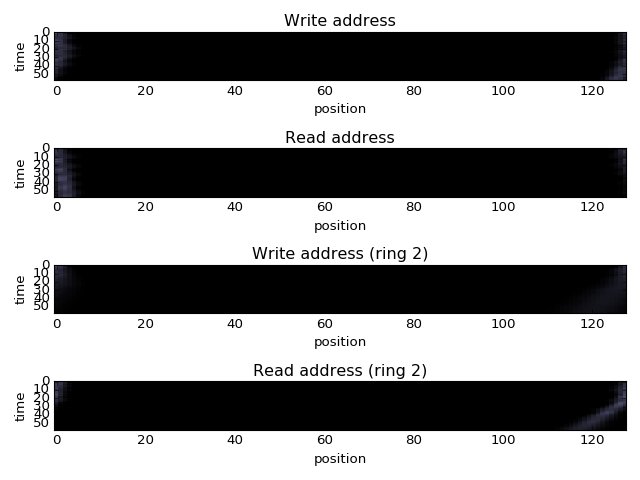

<IPython.core.display.Javascript object>


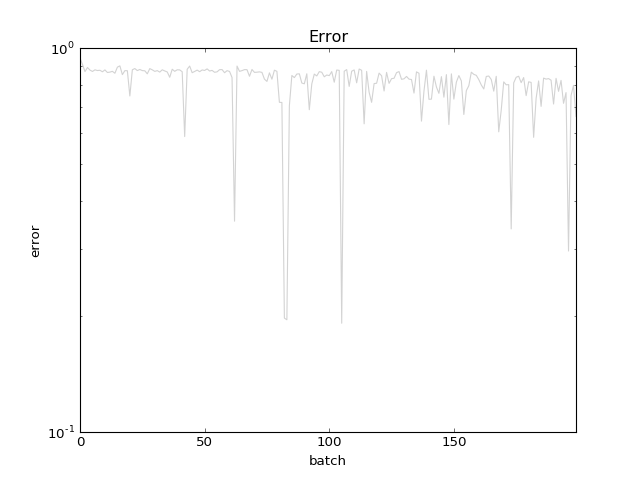

In [7]:
##################
# VISUALISATIONS #
##################

num_subplots = 2

if( use_model == 'pattern_ntm' ):
    num_subplots = 4

plt.figure(1)
ax1 = plt.subplot(num_subplots,1,1)
ax2 = plt.subplot(num_subplots,1,2)

ax1.imshow(np.stack(write_addresses_val), cmap='bone', interpolation='nearest', aspect='auto')
ax1.set_title('Write address')
ax1.set_xlabel('position')
ax1.set_ylabel('time')

ax2.imshow(np.stack(read_addresses_val), cmap='bone', interpolation='nearest', aspect='auto')
ax2.set_title('Read address')
ax2.set_xlabel('position')
ax2.set_ylabel('time')

if( use_model == 'pattern_ntm' ):
    ax3 = plt.subplot(num_subplots,1,3)
    ax4 = plt.subplot(num_subplots,1,4)

    ax3.imshow(np.stack(write_addresses2_val), cmap='bone', interpolation='nearest', aspect='auto')
    ax3.set_title('Write address (ring 2)')
    ax3.set_xlabel('position')
    ax3.set_ylabel('time')

    ax4.imshow(np.stack(read_addresses2_val), cmap='bone', interpolation='nearest', aspect='auto')
    ax4.set_title('Read address (ring 2)')
    ax4.set_xlabel('position')
    ax4.set_ylabel('time')    

plt.tight_layout()

plt.figure(2)
ax3 = plt.subplot(1,1,1)
sc = pandas.Series(error_means)
ma = sc.rolling(window=500).mean()
ax3.plot(sc.index, sc, color='lightgray')
ax3.plot(ma.index, ma, color='red')
ax3.set_yscale('log')
ax3.set_xlim(sc.index.min(), sc.index.max())
ax3.set_title('Error')
ax3.set_xlabel('batch')
ax3.set_ylabel('error')

plt.show()

In [8]:
###########
# TESTING #
###########

# Restore the weights from training
sess = tf.Session()
saver.restore(sess,save_path)

inputs_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]
targets_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size,memory_address_size, memory_content_size)
    cell = ntm.NTM(state_size,input_size,controller_state_size,memory_address_size,memory_content_size, powers_ring1) 
    
if( use_model == 'pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, memory_address_size, memory_content_size, powers_ring1)
    cell = ntm.PatternNTM(state_size,input_size,controller_state_size,memory_address_size,memory_content_size, powers_ring1, powers_ring2)

# Set up test graph
rnn_outputs_test = []
reuse = True
for i in range(Ntest + Ntest_out):
    output, state = cell(inputs_test[i],state,'NTM',reuse)
    rnn_outputs_test.append(output)

with tf.variable_scope("final_layer",reuse=True):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size])

logits_test = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs_test]
prediction_test = [tf.nn.log_softmax(logit) for logit in logits_test] 
mask = [tf.sign(tf.reduce_max(tf.abs(targets_test[i]))) for i in range(Ntest + Ntest_out)]
mistakes_test = [tf.not_equal(tf.argmax(targets_test[i], 1), tf.argmax(prediction_test[i], 1)) for i in range(Ntest + Ntest_out)]
errors_test = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes_test]
errors_test_mask = [errors_test[i] * mask[i] for i in range(Ntest + Ntest_out)]
mean_error_test = tf.add_n(errors_test_mask)
mean_error_test /= tf.add_n(mask)

#### RUN TEST ####

no_of_batches = int(num_test/batch_size)

seq_length = Ntest
print("Testing on sequences of length " + str(seq_length-2))
print("")

error_means = []
for j in range(no_of_batches):
    inp = []
    out = []

    for z in range(batch_size):
        a = [random.randint(0,num_classes-3) for k in range(seq_length-2)]        
        fa = func_to_learn(a)
        a = [init_symbol] + a + [term_symbol] + [term_symbol for k in range(Ntest+Ntest_out-seq_length)]            
        a_onehot = [one_hots[e] for e in a]
                            
        fa_onehot = [[0.0]*num_classes for k in range(seq_length-1)] + \
                    [one_hots[e] for e in fa] + \
                    [[0.0]*num_classes for k in range(Ntest+Ntest_out-(seq_length-1)-len(fa))]
        
        inp.append(np.array(a_onehot))
        out.append(np.array(fa_onehot))        
        
    feed_dict = {}
    for d in range(Ntest + Ntest_out):
        in_node = inputs_test[d]
        ti = []
        for k in range(batch_size):
            ti.append(inp[k][d])
        feed_dict[in_node] = np.array(ti)

    for d in range(Ntest + Ntest_out):
        out_node = targets_test[d]
        to = []
        for k in range(batch_size):
            to.append(out[k][d])
        feed_dict[out_node] = np.array(to)
            
    current_mean = sess.run(mean_error_test, feed_dict)
    error_means.append(current_mean)
    print("Batch - " + str(j+1) + ", Mean error - " + str(current_mean))

final_error = np.mean(error_means)

print("")        
print("###########")
print("# Summary #")
print("###########")
print("")
print("model         - " + use_model)
print("task name     - " + task)
print("epochs        - " + str(epoch))
print("num_classes   - " + str(num_classes))
print("N             - " + str(N))
#print("N_out         - " + str(N_out))
print("Ntest         - " + str(Ntest))
#print("Ntest_out     - " + str(Ntest_out))
print("ring 1 powers - " + str(powers_ring1))
print("ring 2 powers - " + str(powers_ring2))
print("# weights     - " + str(ntm.count_number_trainable_params()))
print("(css,mas,mcs) - (" + str(controller_state_size) + "," + str(memory_address_size) + "," + str(memory_content_size) + ")")
#print("train percent - " + str(training_percent))
print("num_training  - " + str(num_training)) #+ "/" + str((num_classes-2)**(N-2)))
print("num_test      - " + str(num_test)) #+ "/" + str((num_classes-2)**(N-2)))
print("")
print("")
print("error         - " + str(final_error))
sess.close()

Testing on sequences of length 33

Batch - 1, Mean error - 0.854545
Batch - 2, Mean error - 0.849576
Batch - 3, Mean error - 0.854667
Batch - 4, Mean error - 0.852606
Batch - 5, Mean error - 0.846303
Batch - 6, Mean error - 0.851758
Batch - 7, Mean error - 0.858182
Batch - 8, Mean error - 0.85297
Batch - 9, Mean error - 0.858303
Batch - 10, Mean error - 0.852848
Batch - 11, Mean error - 0.850303
Batch - 12, Mean error - 0.856848
Batch - 13, Mean error - 0.851152
Batch - 14, Mean error - 0.852606
Batch - 15, Mean error - 0.851879
Batch - 16, Mean error - 0.850303
Batch - 17, Mean error - 0.851636
Batch - 18, Mean error - 0.860848
Batch - 19, Mean error - 0.843273
Batch - 20, Mean error - 0.854182
Batch - 21, Mean error - 0.848606
Batch - 22, Mean error - 0.849212
Batch - 23, Mean error - 0.859879
Batch - 24, Mean error - 0.853939
Batch - 25, Mean error - 0.852
Batch - 26, Mean error - 0.857455
Batch - 27, Mean error - 0.846545
Batch - 28, Mean error - 0.849333
Batch - 29, Mean error - 0